# Testing the posterior distribution

Test i want to perform:
- See if this method is sensitive to the size of $N_o$
- See if the algorithm improves with the number of interventional samples
- Interventional vs Observational samples
- Vary the simulated noise levels
- Vary the degree of edges for the graphs
- (Maybe try different graph structures)

In [ ]:
import os
import itertools
os.chdir("/vol/bitbucket/jd123/causal_bayes_opt/")
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from graphs.graph_erdos_renyi import ErdosRenyiGraph
from posterior_model.model import LinearSCMModel, NonLinearSCMModel
from graphs.data_setup import setup_observational_interventional
import numpy as np

MEC SIZE: 4


INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-08-17 14:24:46.433312: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
INFO:root:Sampling the observational data
INFO:root:Sampling the interventional data


GT causal graph
[[0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]
Expected degree: 0.6


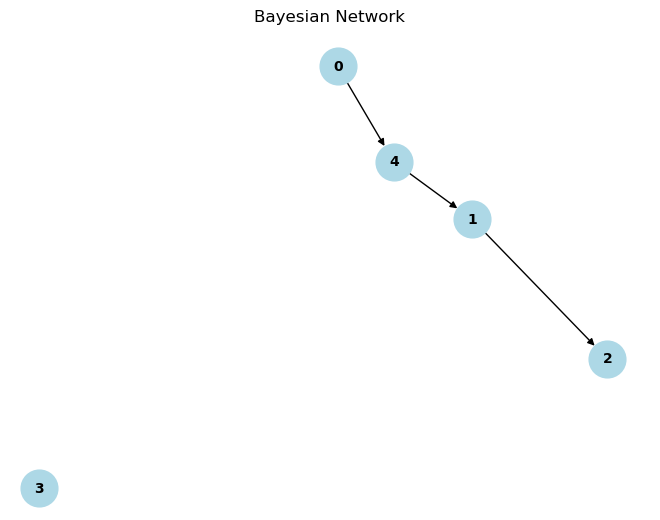

In [ ]:
graph = ErdosRenyiGraph(num_nodes=10, nonlinear=False)
D_O, D_I, _ = setup_observational_interventional(graph_type=None, n_obs=100, n_int = 2, graph=graph)
graph.show_graphical_model()
graph.set_target('2')

In [ ]:
# Function to standardize data
def standardize(data, mean, std):
    return (data - mean) / std


# Function to reverse the standardization
def reverse_standardize(data, mean, std):
    return (data * std) + mean


def scale_data(D_O, D_I):
    input_keys = [key for key in D_O.keys() if key != graph.target]
    means = {key: np.mean(D_O[key]) for key in input_keys}
    stds = {key: np.std(D_O[key]) for key in input_keys}

    D_O_scaled = {}
    for key in D_O:
        if key in input_keys:
            D_O_scaled[key] = standardize(
                D_O[key], means[key], stds[key]
            )
        else:
            D_O_scaled[key] = D_O[key]

    interventions = D_I.keys()
    D_I_scaled = {intervention: {} for intervention in interventions}
    for intervention in interventions:
        for key in D_I[intervention]:
            if key in input_keys:
                D_I_scaled[intervention][key] = standardize(
                    D_I[intervention][key], means[key], stds[key]
                )
            else:
                D_I_scaled[intervention][key] = D_I[intervention][key]

    D_O_scaled = D_O_scaled
    D_I_scaled = D_I_scaled
    return D_O_scaled, D_I_scaled

In [21]:
import pickle
os.chdir("/vol/bitbucket/jd123/causal_bayes_opt/")
with open("results/posterior/Erdos5/run1_nonlinear_100_nint_p_1.0_D_1000_noise_None.pickle", "rb") as file:
    results = pickle.load(file)

In [22]:
print(results)

{'accuracy': [0.4806863120678851, 0.4798436761750502, 0.5086326290768992, 0.5421025895160232, 0.575573534850245, 0.6025465974470774, 0.6306342069008023, 0.6523862312372223], 'precision': [0.24830971523294043, 0.27652982728465225, 0.3120394898104409, 0.3438927245756827, 0.3763584293194299, 0.4041278518306842, 0.42947619253683883, 0.451556811412249], 'recall': [0.5338210630980411, 0.5943989021322997, 0.620169683118028, 0.6436623661313888, 0.6643990730979814, 0.679502201329943, 0.6785550859017847, 0.6766921056162115], 'f1_score': [0.32504230413876156, 0.3617510342120618, 0.39567915360533207, 0.42728340536287196, 0.4580467757123685, 0.4835800938991352, 0.5021791803689725, 0.5176617496268165]}
